In [54]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import xgboost as xgb
import seaborn as sns
import math as math
import matplotlib.pyplot as plt

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2788, 38)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2788, 903)

In [8]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [9]:
X = MatrixData
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

# Define and Train Model

In [10]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

# random seed here deals with model initialization
clf = xgb.XGBClassifier(objective="binary:logistic", 
                        eval_metric="logloss", 
                        gamma=5, subsample=0.5, 
                        max_delta_step=1, 
                        scale_pos_weight=math.sqrt(1721
/328))
param_grid = {'eta': [0.3],
             'max_depth': [6]}
model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(RECALL_SCORE), cv = 5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [11]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


# Evaluate Model on Train + Test Sets

In [12]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.997176,train
1,0.996459,train
2,0.997418,train
3,0.996004,train
4,0.995761,train
0,0.869573,test
1,0.912704,test
2,0.962313,test
3,0.853938,test
4,0.863848,test


<AxesSubplot:xlabel='stage', ylabel='score'>

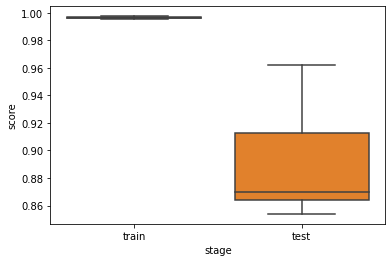

In [13]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [14]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [15]:
FinalModel.model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2.2906224524159793, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
features = [FeatMeta.feature.to_list()]

In [17]:
feat_importances = pd.DataFrame(FinalModel.model.best_estimator_.feature_importances_, index=features, columns=["Importance"])
feat_importances.sort_values(["Importance"], ascending=False, inplace=True)

<AxesSubplot:ylabel='Frequency'>

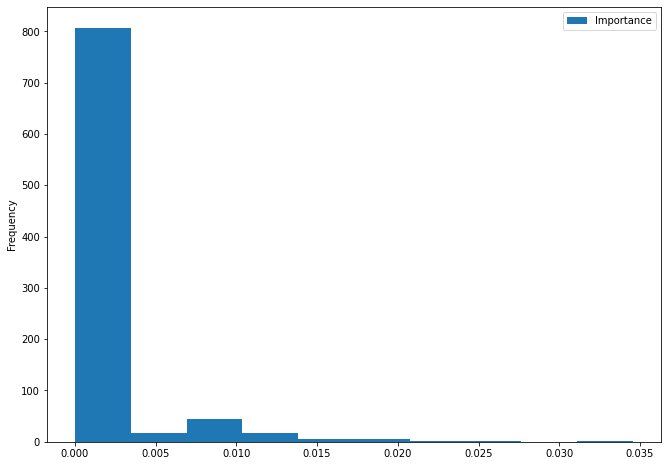

In [18]:
feat_importances.plot(kind="hist", figsize=(11, 8))

<AxesSubplot:>

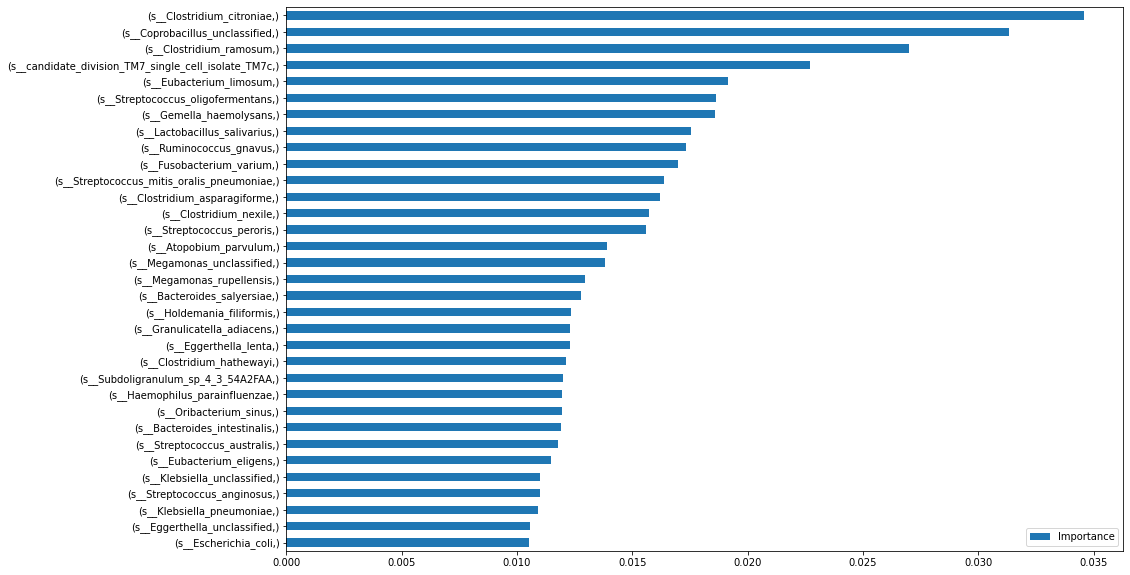

In [19]:
feat_importances = feat_importances[feat_importances>0.01].dropna()
feat_importances.sort_values(["Importance"], ascending=True).plot(kind='barh', figsize=(15,10))

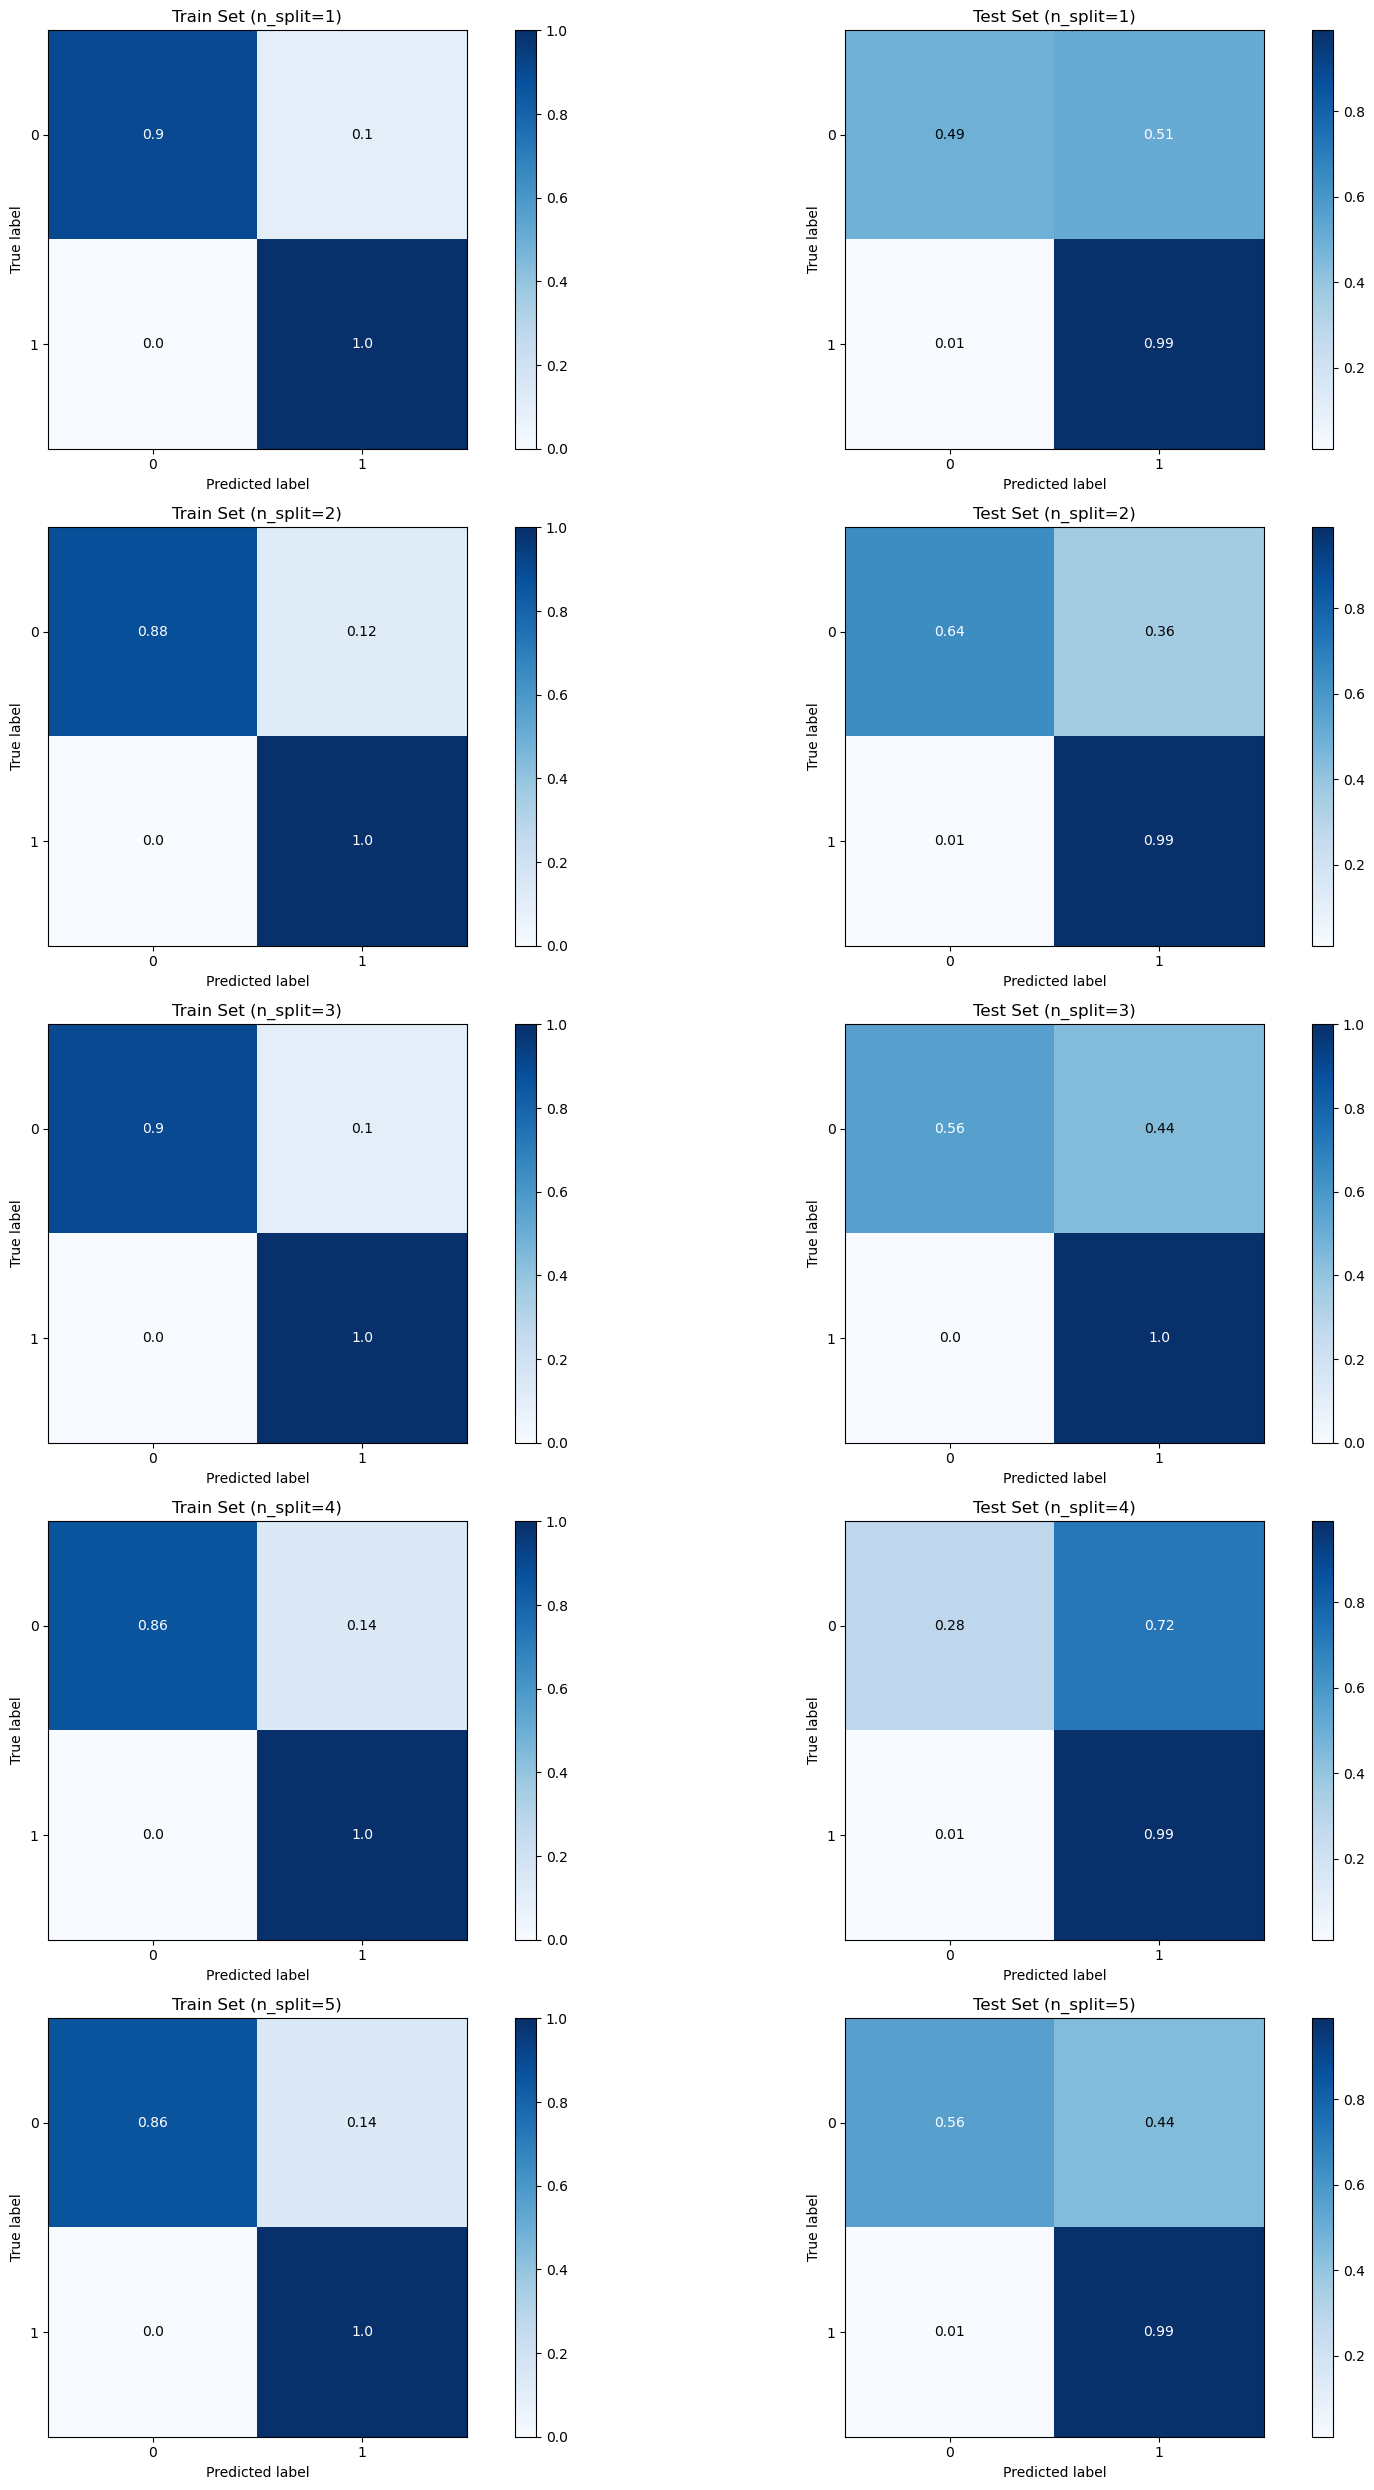

In [20]:
MyMultiTrainTester.plot_confusion(normalize=True)

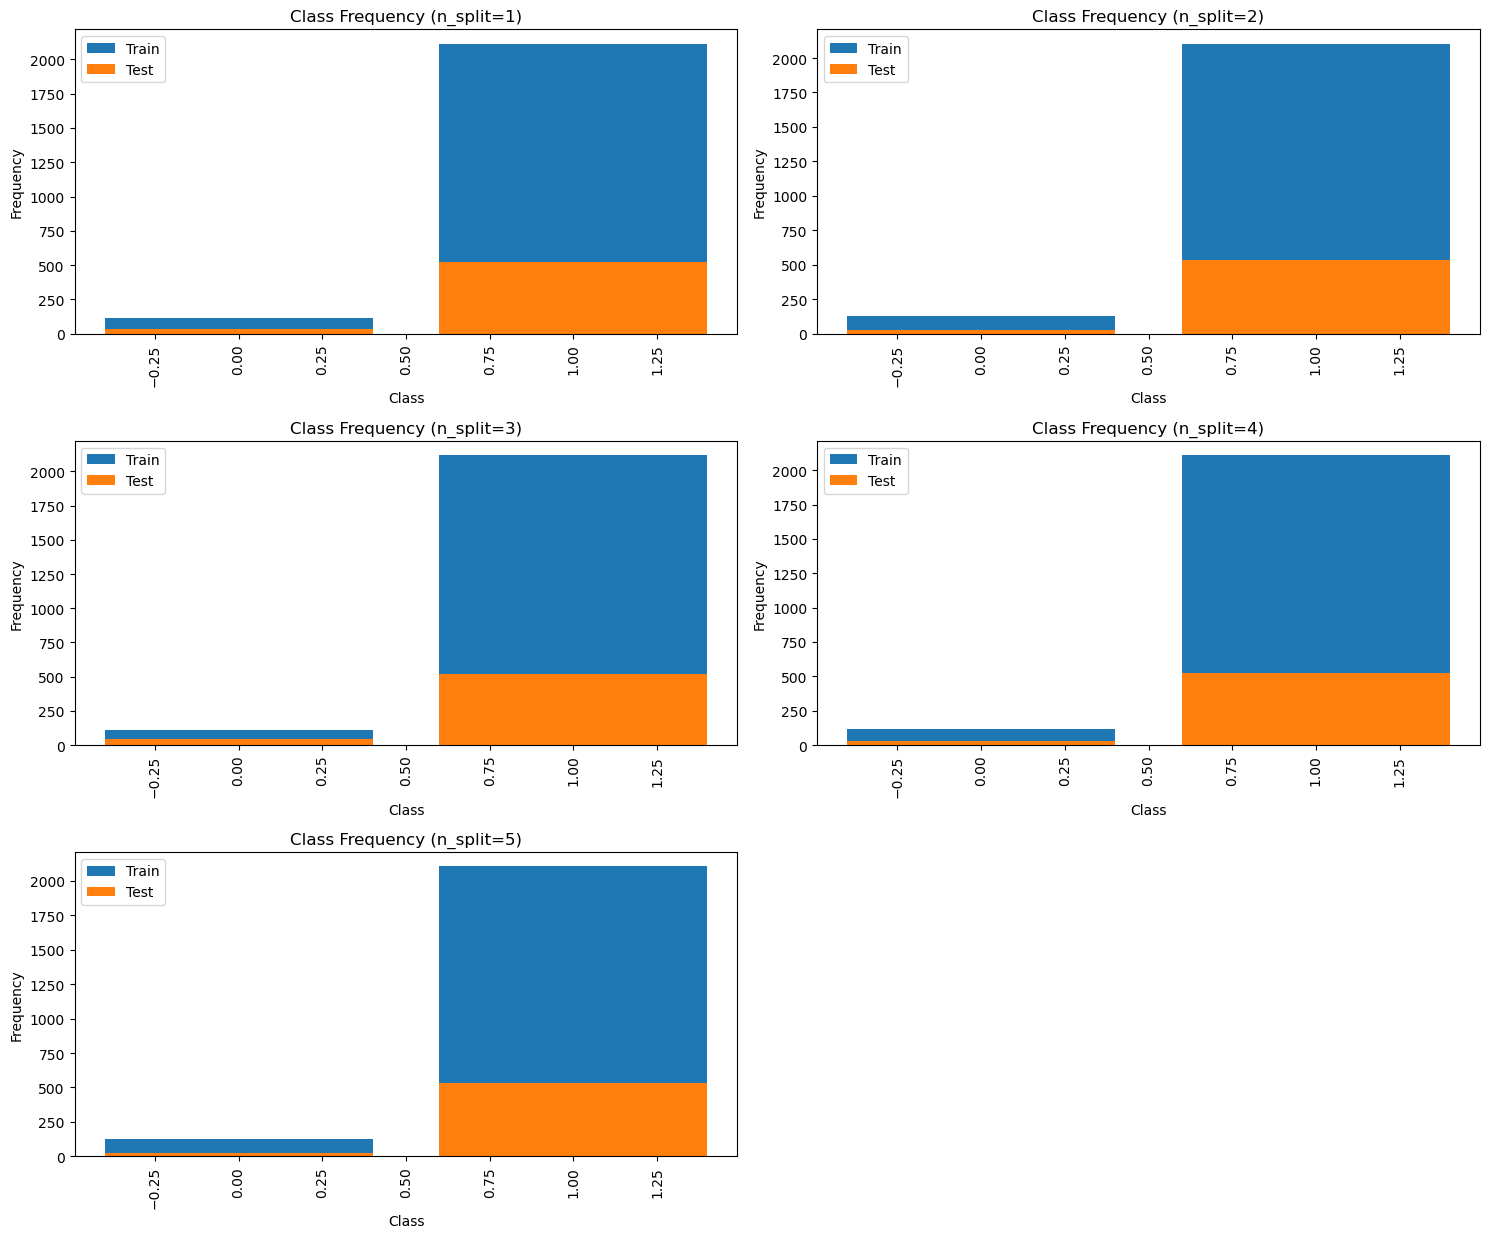

In [21]:
MyMultiTrainTester.plot_class_freq(normalize=True)

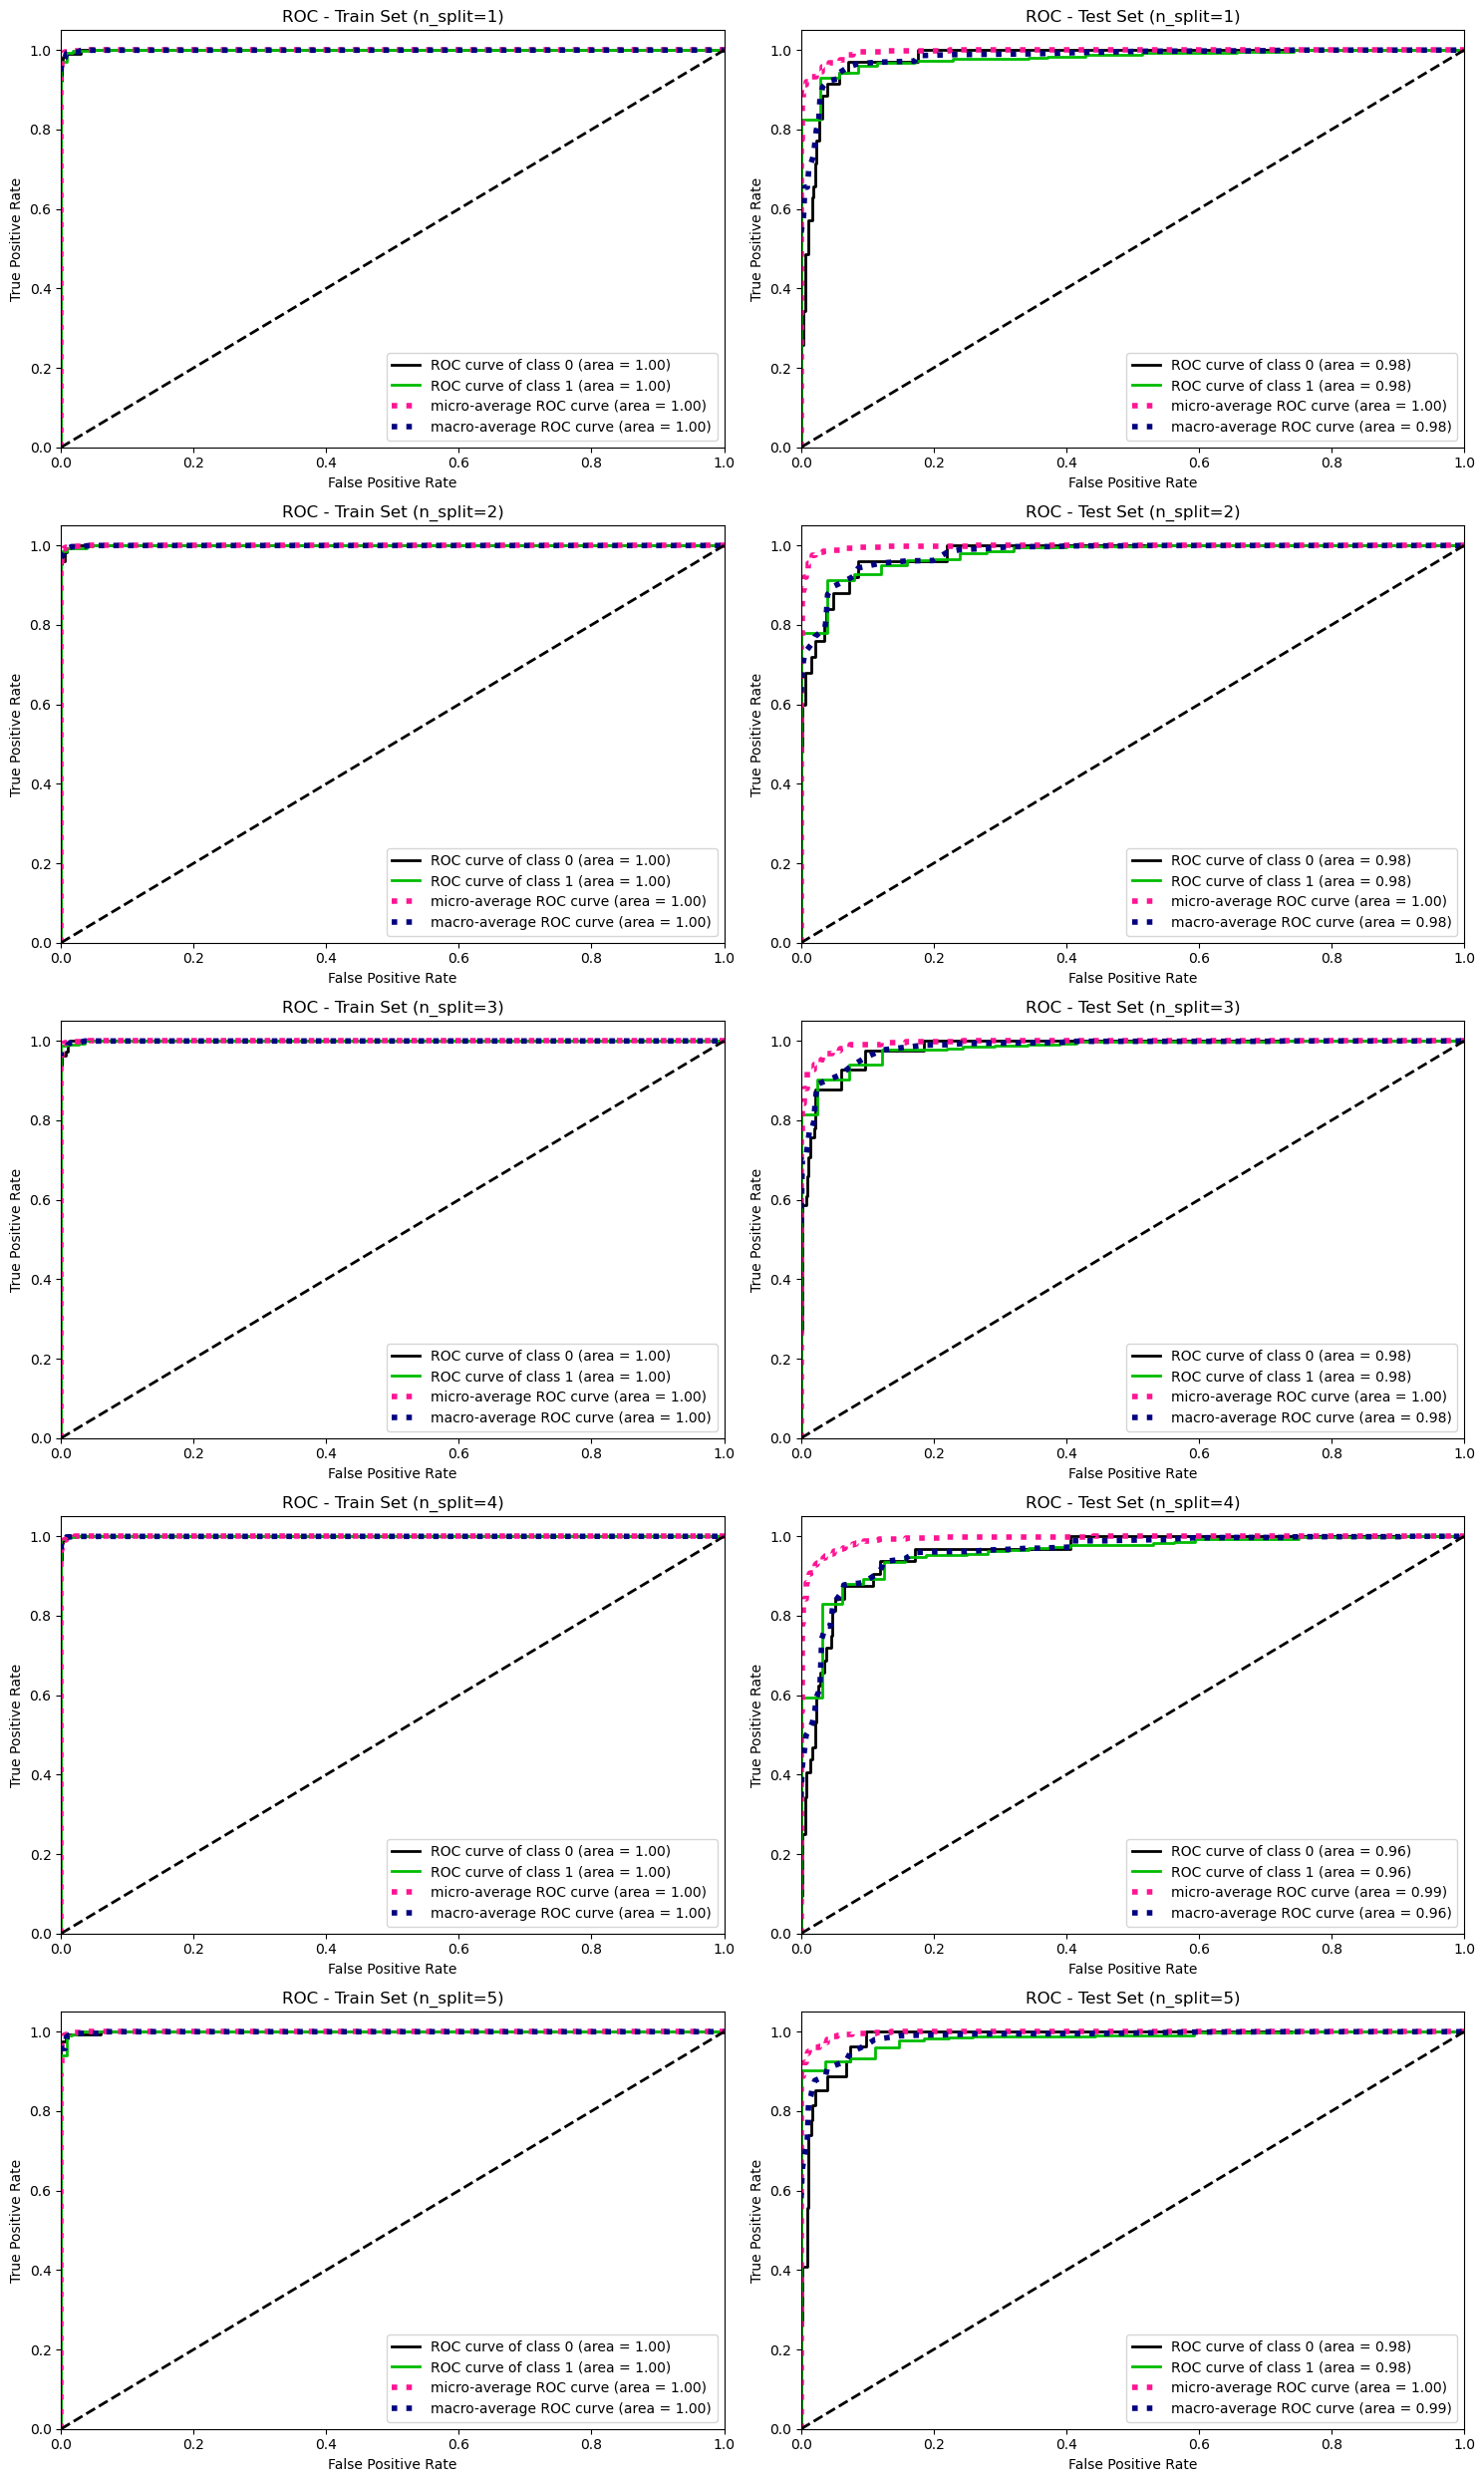

In [22]:
MyMultiTrainTester.plot_roc()

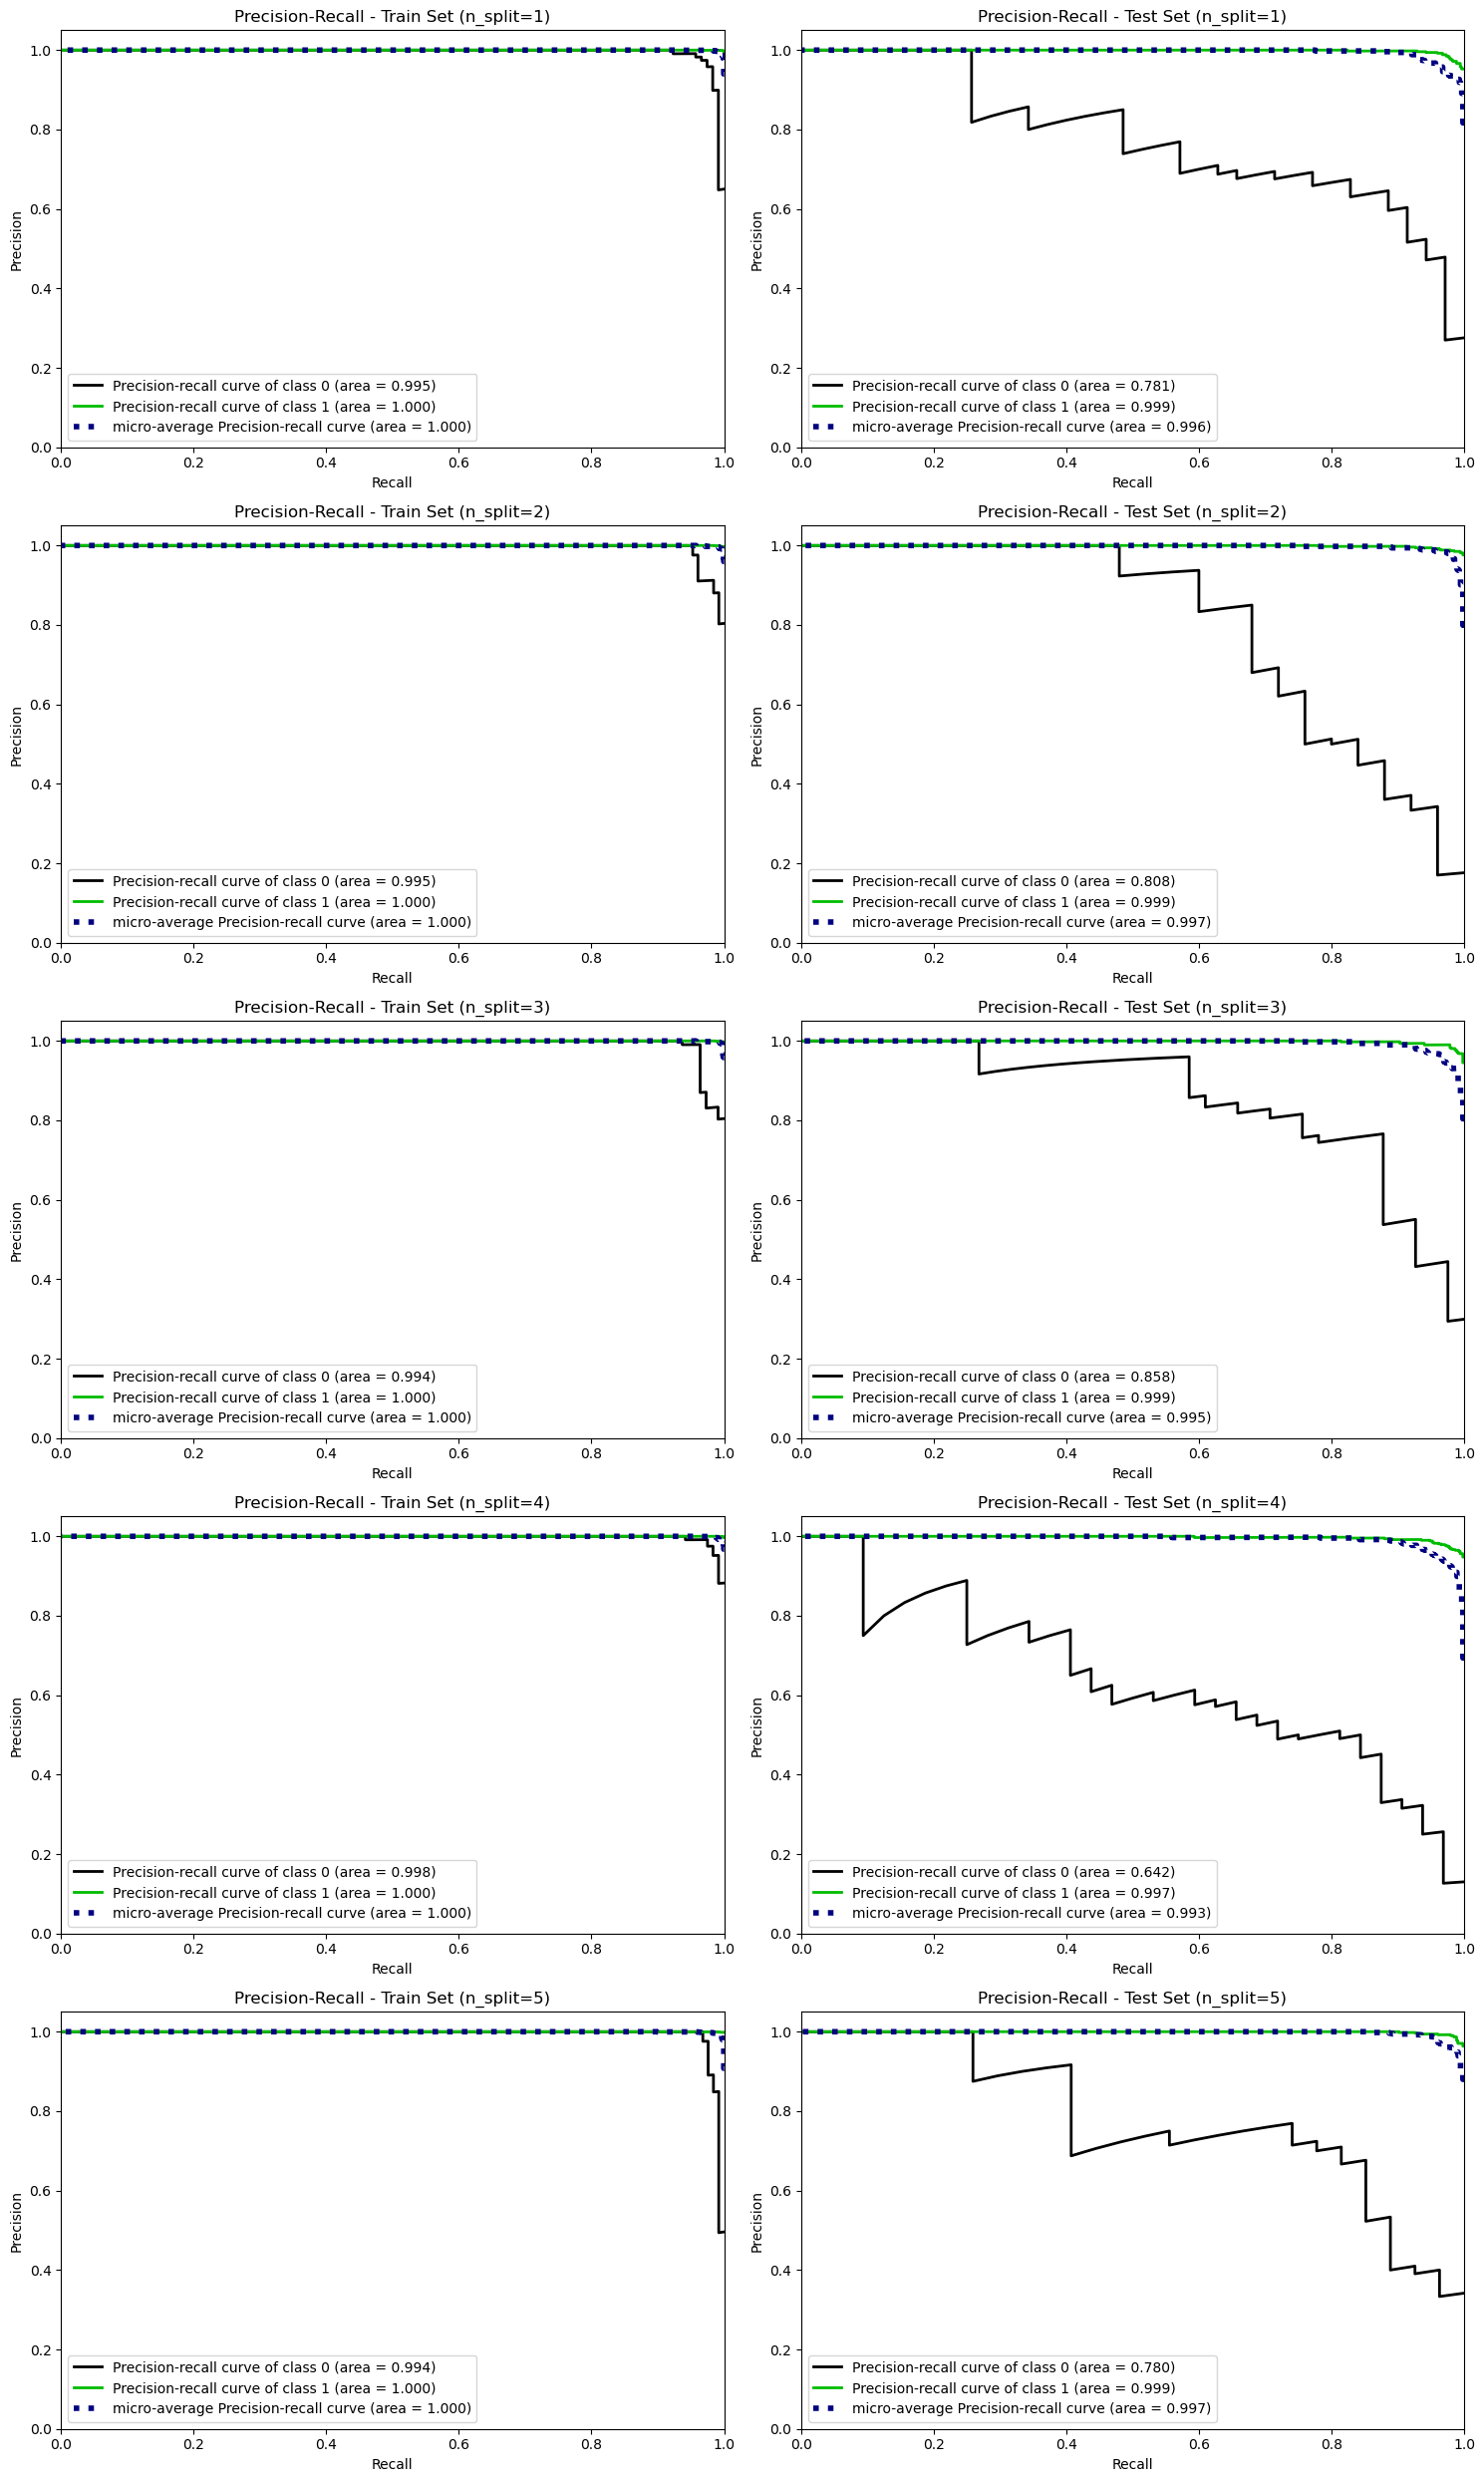

In [23]:
MyMultiTrainTester.plot_precrecall()

# Evaluate Model Performance on ACVD Study Data Only

In [24]:
SampleMeta.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'study',
       'Study No. (From VG sheet (V-*) from SB sheet (S-*))', 'Title of Paper',
       'Author (year)', 'Journal', 'Study Accession',
       'Sample Accession or Sample ID', 'Sample title (ENA/SRA)',
       'Sample title (Paper)', 'Subject Id (If available)', 'Age (Years)',
       'BMI', 'Gender', 'GRoP', 'Phenotype', 'FBG', 'TRIG', 'LDLC', 'CHOL',
       'HDLC', 'Phys_Ex', 'Smoking', 'Residence', 'milk', 'meat', 'alcohol',
       'Diet1', 'Diet2', 'medication', 'Sequencing Platform',
       'Library layout (SINGLE/PAIRED)', 'Read count after Quality control',
       'Healthy', 'age_group', 'age_category'],
      dtype='object')

In [25]:
train_idx0 = MyMultiTrainTester.train_idx[0]
test_idx0 = MyMultiTrainTester.test_idx[0]
SampleMetaTrain = SampleMeta.iloc[train_idx0, :]
SampleMetaTest = SampleMeta.iloc[test_idx0, :]

In [33]:
# get indices
train_idx_study = np.argwhere((SampleMetaTrain['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()
test_idx_study = np.argwhere((SampleMetaTest['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()

In [67]:
# check metadata
SampleMetaTrain.iloc[train_idx_study, :]['Gender'].value_counts()

M    34
F    14
Name: Gender, dtype: int64

In [68]:
SampleMetaTest.iloc[test_idx_study, :]['Gender'].value_counts()

M    34
F    14
Name: Gender, dtype: int64

In [71]:
np.sum(SampleMetaTrain.iloc[train_idx_study, :]['BMI'].to_numpy() == -99)

6

In [72]:
np.sum(SampleMetaTest.iloc[test_idx_study, :]['BMI'].to_numpy() == -99)

2

In [45]:
# Setup data for evaluation
X_train_study = X[train_idx0, :][train_idx_study, :]
y_train_study = y[train_idx0][train_idx_study]
X_test_study = X[test_idx0, :][test_idx_study, :]
y_test_study = y[test_idx0][test_idx_study]

## Train

In [59]:
FinalModel.score(X_train_study, y_train_study, RECALL_SCORE)

0.9189189189189189

In [60]:
X_train_study_transf = FinalModel.transform_X(X_train_study)

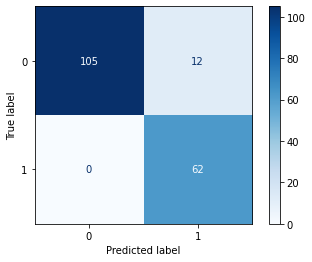

In [61]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues)

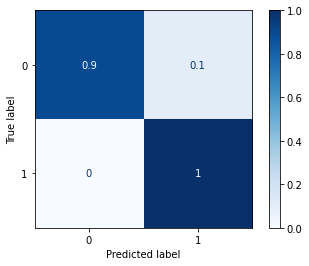

In [62]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, normalize='true', cmap=plt.cm.Blues)

## Test

In [63]:
FinalModel.score(X_test_study, y_test_study, RECALL_SCORE)

0.6370235934664247

In [64]:
X_test_study_transf = FinalModel.transform_X(X_test_study)

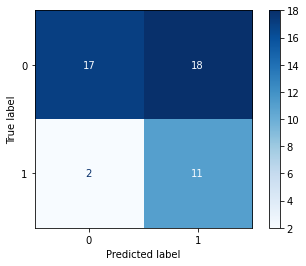

In [65]:
# test confusion matrix using only data from study with ACVD stuff
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues)

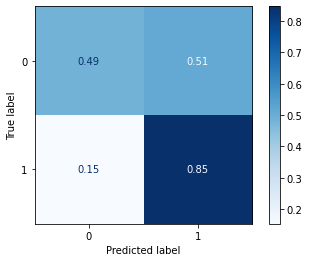

In [66]:
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, normalize='true', cmap=plt.cm.Blues)